In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [3]:
# Import DF of all GCaMP6s library variants
"""
dat is formated with the name of the variant in the index
and a vector of the three z-scores for each amino acid in that variant's
sequence
Ex: The first two amino acid in the GCaMP6s sequence are MG, so the vector 
is
[Z1_M, Z2_M, Z3_M, Z1_G, Z2_G, Z3_G, ...]


lib is the original table published in Chen 2013
"""
dat = pd.read_csv('./varZScore3.csv', index_col = 0)
colsToDrop = dat.nunique()[dat.nunique() == 1].index     # Drop all positions in the library that do not mutate
dat = dat.drop(colsToDrop, axis = 1)

lib = pd.read_csv('./GCaMP6_lib.csv', index_col = 0).drop('OGB1', axis = 0)

In [4]:
# Split data into test, training, and validation set
from sklearn.model_selection import train_test_split
x = dat
y = lib['160 AP !F/F0']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1)

# Reassign x and y to 90% split of data
x = x_train
y = y_train
# x_test.to_csv('./gcamp6s_validation_x.csv')
# y_test.to_csv('./gcamp6s_validation_y.csv')

In [15]:
# Test different models (SVR, RF, GradientBoosting)

# Import models and ShuffleSplit
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import ShuffleSplit
splits = 10       # Number of CV splits
ss = ShuffleSplit(n_splits = splits, test_size = 0.2)
ss.get_n_splits(x_train)

# List of models to train
models = [
    sklearn.linear_model.LinearRegression(),
    sklearn.linear_model.Ridge(),
    sklearn.linear_model.Lasso(),
    sklearn.linear_model.ElasticNet(),
    sklearn.linear_model.LassoLars(),
    sklearn.linear_model.BayesianRidge(),
    sklearn.linear_model.SGDRegressor(),
    sklearn.linear_model.PassiveAggressiveRegressor(),
    SVR(),
    sklearn.neighbors.KNeighborsRegressor(),
    #sklearn.gaussian_process.GaussianProcessRegressor(),
    RandomForestRegressor(),
    sklearn.ensemble.AdaBoostRegressor(),
    GradientBoostingRegressor(),
]

# Empty list for scores of each model for each fold of CV
scores = [[] for model in models]

# Empty list for a sample of predicted and true y-values
yPreds = []
yTests = []

i = 0
for model in models:
    for train_index, test_index in ss.split(x):
        
        # Split into training and test sets using ShuffleSplit
        x_train = x.iloc[train_index]
        y_train = y.iloc[train_index]
        
        x_test = x.iloc[test_index]
        y_test = y.iloc[test_index]
        
        # Fit model, predict fluorescence for test set, record model score
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        scores[i].append(model.score(x_test, y_test))
        
    i += 1
    
    # Record last set of predicted and test values for respective model
    yPreds.append(y_pred)
    yTests.append(y_test)

/Users/nguyenva/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/Users/nguyenva/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveRegressor in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


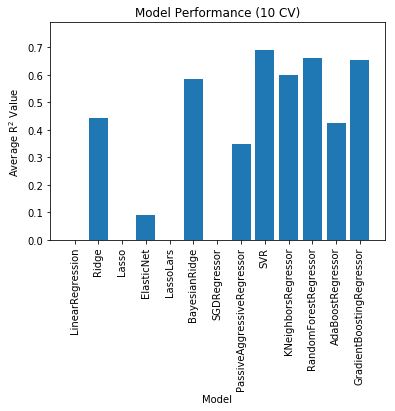

In [24]:
# Plot average score for each model
modelNames = [str(model).split('(')[0] for model in models]
scoreAve = np.mean(scores, axis = 1)
tickLoc = range(1, len(models) + 1)

plt.bar(tickLoc, scoreAve)
plt.xticks(tickLoc, modelNames, rotation = 'vertical')
plt.ylim([0, max(scoreAve) + 0.1])
plt.ylabel('Average R$^2$ Value')
plt.xlabel('Model')
plt.title('Model Performance (10 CV)')
plt.show()

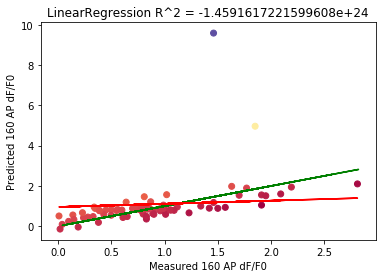

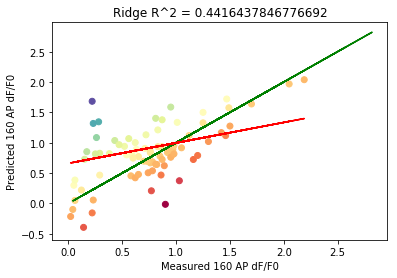

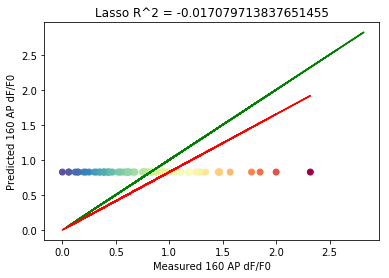

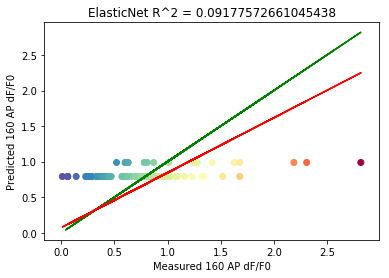

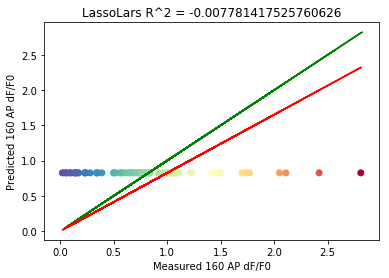

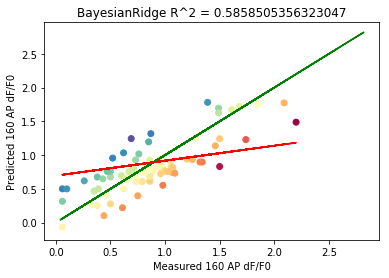

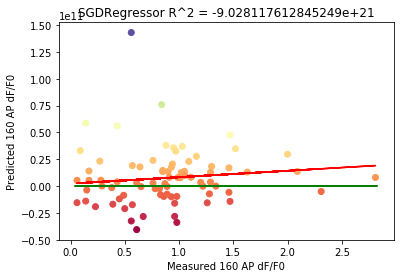

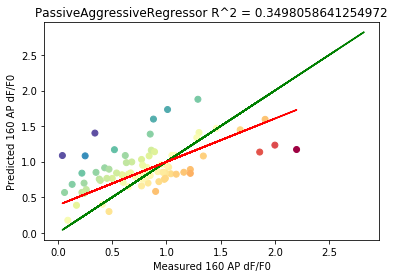

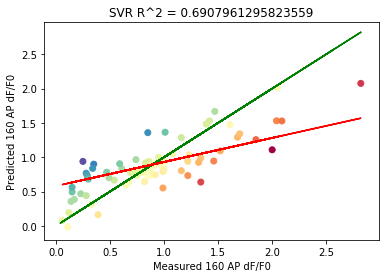

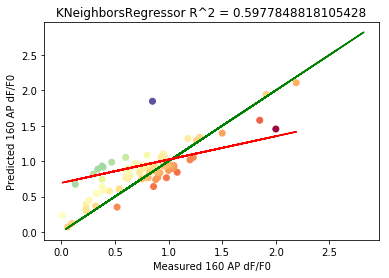

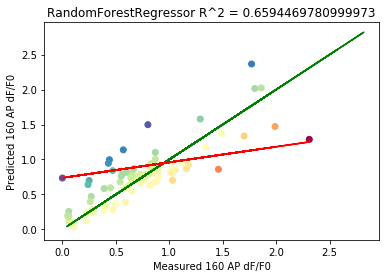

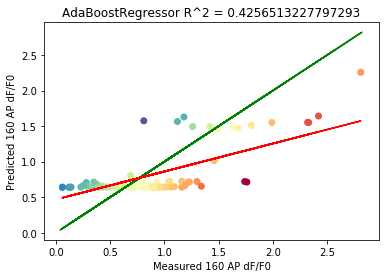

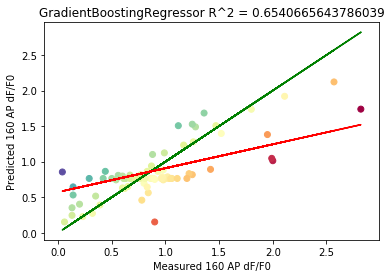

In [20]:
# Plot performance of each model
"""
Generate plots of predicted values~expected values. The points are colored by 
their residual to the 1:1 line. The green line is the line for a perfect model
and the red line is the line of best fit for the model.
"""
for idx in range(0, len(models)):
    resid = yPreds[idx] - yTests[idx]
    plt.plot(y_test, y_test, 'g')                   # 1:1 line for perfect model (green)

    b, m = np.polyfit(yTests[idx], yPreds[idx], 1)
    plt.plot(yTests[idx], b + m * yTests[idx], 'r') # Line of best fit for predicted~measured (red)

    plt.scatter(yTests[idx], yPreds[idx], c = resid, cmap = 'Spectral')
    plt.xlabel('Measured 160 AP dF/F0')
    plt.ylabel('Predicted 160 AP dF/F0')
    plt.title(modelNames[idx] + ' R^2 = ' + str(scoreAve[idx]))
    plt.show()